In [1]:
"""
Purpose: This will use a lot of the functions
for analyzing the different GMM approaches

"""

'\nPurpose: This will use a lot of the functions\nfor analyzing the different GMM approaches\n\n'

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")
%matplotlib inline

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import dimensionality_reduction_utils as dr
import clustering_utils as cl
dr = reload(dr)
cl = reload(cl)
import pandas_utils as pu

from sklearn.preprocessing import StandardScaler
import time
from collections import Counter
import copy
np.set_printoptions(suppress=True)

In [107]:
from sklearn import mixture

# Importing the Data

In [108]:
df = pd.read_pickle("neuron_dendrite_path_data")
df_filtered = pu.filter_away_nan_rows(df)

# Get the distribution of the limb starts

Text(0.5, 1.0, 'Soma Angle Distribution ')

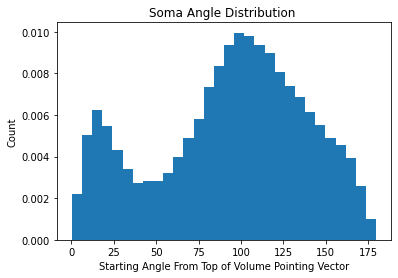

In [109]:
fig,ax = plt.subplots(1,1)
soma_angles =df_filtered[::4]["soma_angle"].to_numpy()

ax.hist(soma_angles,bins=30,density=True)
ax.set_xlabel("Starting Angle From Top of Volume Pointing Vector")
ax.set_ylabel("Count")
ax.set_title("Soma Angle Distribution ")

# Extracting the Vectors we want to process (excluding the soma angle)

In [110]:
columns_picked = df_filtered.columns[6:].to_numpy()
columns_picked

array(['n0_width_median_mesh_center',
       'n0_width_no_spine_median_mesh_center', 'n0_n_spines',
       'n0_total_spine_volume', 'n0_spine_volume_median',
       'n0_spine_volume_density', 'n0_skeletal_length', 'n0_parent_angle',
       'n0_sibling_angle', 'n1_width_median_mesh_center',
       'n1_width_no_spine_median_mesh_center', 'n1_n_spines',
       'n1_total_spine_volume', 'n1_spine_volume_median',
       'n1_spine_volume_density', 'n1_skeletal_length', 'n1_parent_angle',
       'n1_sibling_angle'], dtype=object)

In [111]:
# Scaling the Data
df_data = df_filtered[columns_picked].to_numpy()
scaler = StandardScaler()
df_data_scaled = scaler.fit_transform(df_data)

#df_data_reversed = scaler.inverse_transform(df_data_scaled,copy=True)

data_df_normalized = pd.DataFrame(df_data_scaled)
#add on the columns
data_df_normalized.columns = columns_picked
data_df_normalized

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,-1.307408,-1.211303,-0.563713,-0.393487,-0.820227,-0.348209,-0.658634,-0.555927,2.580471,0.081006,0.289593,-0.593209,-0.622582,0.357911,-0.830670,0.882914,-1.052724,0.656866
1,-1.307408,-1.211303,-0.563713,-0.393487,-0.820227,-0.348209,-0.658634,-0.555927,2.580471,-1.312900,-1.230876,-0.752970,-0.732427,-0.901012,-0.917901,-0.616442,1.497255,0.656866
2,-1.935280,-1.841565,-0.563713,-0.393487,-0.820227,-0.348209,-0.591251,3.478030,2.580471,-1.394242,-1.319978,-0.752970,-0.732427,-0.901012,-0.917901,-0.792687,-0.475669,-1.742013
3,-1.935280,-1.841565,-0.563713,-0.393487,-0.820227,-0.348209,-0.591251,3.478030,2.580471,-1.534974,-1.474135,-0.752970,-0.732427,-0.901012,-0.917901,-0.778347,-1.384062,-1.742013
4,-0.312965,-0.213075,-0.563713,-0.393487,-0.820227,-0.348209,-0.459840,-0.177505,-1.244099,0.504117,0.227209,1.004394,0.705289,0.179588,0.621027,0.410959,-0.862051,-0.974313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278287,0.253897,0.355945,-0.563713,-0.393487,-0.820227,-0.348209,-0.793917,0.329122,1.425331,-0.159848,0.032174,-0.513329,-0.552690,0.338898,-0.468013,-0.365497,1.562012,0.739752
278288,-0.126348,-0.025747,-0.437556,-0.309463,0.513432,-0.199089,-0.270056,1.352386,1.425331,0.115213,0.003587,0.245533,0.498456,0.372328,0.318889,0.499524,-1.399172,-0.753286
278289,-0.126348,-0.025747,-0.437556,-0.309463,0.513432,-0.199089,-0.270056,1.352386,1.425331,0.035701,-0.024399,0.285473,-0.003151,-0.399218,-0.382360,1.031757,0.646782,-0.753286
278290,-0.525829,-0.503808,0.887093,0.578067,-0.179997,0.142657,1.191045,1.376693,-0.934671,-1.387596,-1.312697,-0.752970,-0.732427,-0.901012,-0.917901,-0.804355,2.144463,1.211276


# Creating Train and Test datasets

In [112]:
def indices_of_soma_angle(df_curr,angle_interval):
    return np.where((df_curr["soma_angle"]>=angle_interval[0]) & 
           (df_curr["soma_angle"]<=angle_interval[-1]))[0]

In [113]:
basal_indices = indices_of_soma_angle(df_filtered,[100,115])
axon_indices = indices_of_soma_angle(df_filtered,[165,180])
apical_indices = indices_of_soma_angle(df_filtered,[0,20])

print(f"# basal paths = {len(basal_indices)}\n",
     f"# axon paths = {len(axon_indices)}\n",
     f"# apical paths = {len(apical_indices)}\n")

# basal paths = 39892
 # axon paths = 8785
 # apical paths = 25478



In [114]:
# picking 10000 of data randomly to test on
random_N = 8000

basal_indices_random =  basal_indices[np.random.choice(np.arange(len(basal_indices)),size=random_N,replace=False)]
axon_indices_random =  axon_indices[np.random.choice(np.arange(len(axon_indices)),size=random_N,replace=False)]
apical_indices_random =  apical_indices[np.random.choice(np.arange(len(apical_indices)),size=random_N,replace=False)]

print(f"After Picking a Random {random_N} subset of paths:\n"
      f"# basal paths = {len(basal_indices_random)}\n",
     f"# axon paths = {len(axon_indices_random)}\n",
     f"# apical paths = {len(apical_indices_random)}\n")

After Picking a Random 8000 subset of paths:
# basal paths = 8000
 # axon paths = 8000
 # apical paths = 8000



# # Part 1: GMM on scaled Dataset (Original Basis)

In [115]:
title_suffix = f"Normalized Original Data"

axon_data_scaled = data_df_normalized.iloc[axon_indices_random]
basal_data_scaled = data_df_normalized.iloc[basal_indices_random]
apical_data_scaled = data_df_normalized.iloc[apical_indices_random]
data_total_scaled = copy.copy(data_df_normalized)

print(f"# apical paths = {len(axon_data_scaled)}\n",
     f"# basal paths = {len(basal_data_scaled)}\n",
     f"# axon paths = {len(apical_data_scaled)}\n")

# apical paths = 8000
 # basal paths = 8000
 # axon paths = 8000



In [116]:
gmm = reload(gmm)

X_train = data_total_scaled
scaler_obj = scaler

scaled_original_results = gmm.gmm_analysis(X_train,
                scaler_obj=scaler)



------Working on clusters K=2-----
Convergence status = True
Total time for GMM = 5.706549882888794


------Working on clusters K=3-----
Convergence status = True
Total time for GMM = 31.529309034347534


------Working on clusters K=4-----
Convergence status = True
Total time for GMM = 56.33549404144287


------Working on clusters K=5-----
Convergence status = True
Total time for GMM = 55.14264130592346


------Working on clusters K=6-----
Convergence status = True
Total time for GMM = 42.766899824142456


------Working on clusters K=7-----
Convergence status = True
Total time for GMM = 49.377135276794434


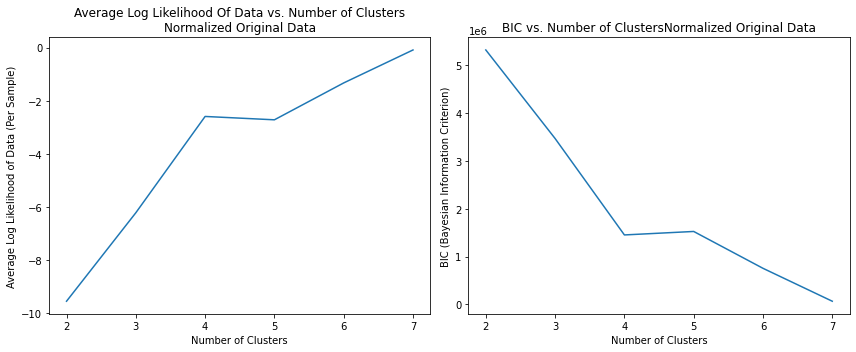

In [117]:
gmm.plot_BIC_and_Likelihood(scaled_original_results,title_suffix=title_suffix)

# looking at statistcs of a certain cluster and analyzing the stats

In [123]:
gmm = reload(gmm)

print_tables = [2,3,4]
advanced_stats_per_k = dict()
verbose = True
classification_types = ["hard"]#["hard","soft"]


for curr_K in scaled_original_results.keys():
    if verbose:
        print(f"\n\n----Working on Advanced Statistics for n_clusters = {curr_K}----\n")
        
    model = scaled_original_results[curr_K]["model"]
    
    labeled_data = dict(
                     Axon=axon_data_scaled,
                     Basal=basal_data_scaled,
                     Apical=apical_data_scaled
    )

    labeled_data_classification,df_class=gmm.category_classifications(
                                model,
                                labeled_data,
                                classification_types=classification_types)
    if curr_K in print_tables:
        print(f"Clustering Numbers By Neuroscience Category for K = {model.n_components}")
        print(df_class.to_markdown())
        
    cl_stats_df = gmm.cluster_stats_dataframe(labeled_data_classification)
    
    if curr_K in print_tables:
        print(f"Clustering Advanced Statistics By Neuroscience Category for K = {curr_K}")
        print(cl_stats_df.to_markdown())
        
    column_restriction = ["category","highest_cluster_perc","purity","n_clusters"]
    cl_stats_restricted = cl_stats_df.query("classification=='hard'")[column_restriction]
    
    advanced_stats_per_k[curr_K] = cl_stats_restricted
    




----Working on Advanced Statistics for n_clusters = 2----

Clustering Numbers By Neuroscience Category for K = 2
|    | classification   | category   |   n_clusters |   cl_0 |   cl_1 |
|---:|:-----------------|:-----------|-------------:|-------:|-------:|
|  2 | hard             | Apical     |            2 |   1323 |   6677 |
|  0 | hard             | Axon       |            2 |   6007 |   1993 |
|  1 | hard             | Basal      |            2 |   1826 |   6174 |
Clustering Advanced Statistics By Neuroscience Category for K = 2
|    | category   | classification   |   n_clusters |   highest_cluster |   highest_cluster_perc |   n_clusters_80.0 |   purity |
|---:|:-----------|:-----------------|-------------:|------------------:|-----------------------:|------------------:|---------:|
|  2 | Apical     | hard             |            2 |                 1 |               0.834625 |                 1 | 0.39932  |
|  0 | Axon       | hard             |            2 |                

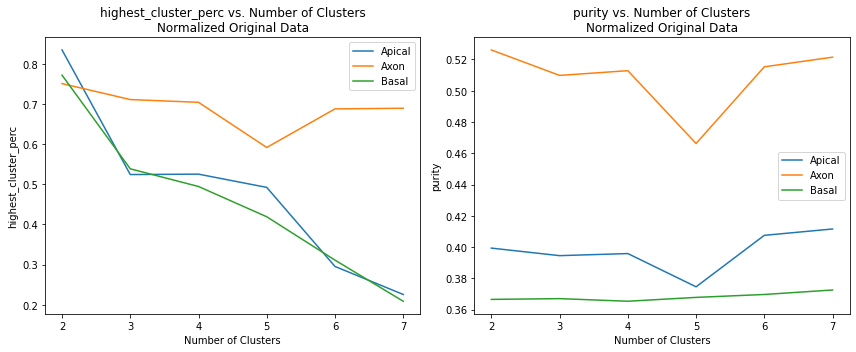

In [128]:
gmm.plot_advanced_stats_per_k(advanced_stats_per_k,title_suffix=title_suffix)

# Part 2: GMM on un-scaled Dataset (Original Basis)

In [173]:
labeled_data_indices = dict(
                     Axon=axon_indices_random,
                     Basal=basal_indices_random,
                     Apical=apical_indices_random
    )

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Restricting to columns : ['n0_width_median_mesh_center', 'n0_skeletal_length', 'n0_parent_angle', 'n0_sibling_angle', 'n1_width_median_mesh_center', 'n1_skeletal_length', 'n1_parent_angle', 'n1_sibling_angle']
# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Convergence status = True
Total time for GMM = 3.435427665710449


------Working on clusters K=3-----
Convergence status = True
Total time for GMM = 4.068761825561523


------Working on clusters K=4-----
Convergence status = True
Total time for GMM = 15.32123589515686


------Working on clusters K=5-----
Convergence status = True
Total time for GMM = 19.922805070877075


------Working on clusters K=6-----
Convergence status = True
Total time for GMM = 11.290855884552002
# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Working on Advance

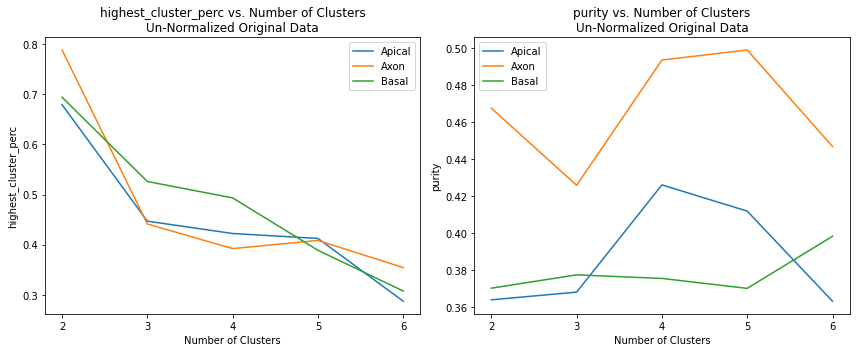

In [175]:
gmm = reload(gmm)
unscaled_columns_picked =[k for k in df_filtered_unscaled.columns if "spine" not in k]


gmm.gmm_pipeline(df_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Un-Normalized Original Data",
                 columns_picked = unscaled_columns_picked,
                 possible_K = [2,3,4,5,6],
                 apply_normalization=False,
                 apply_pca=False,
                 
                )

# looking at statistcs of a certain cluster and analyzing the stats